<a href="https://colab.research.google.com/github/MatheoCruz/BLR_imputation_perovskite/blob/main/Evaluacion_imputacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROYECTO DE GRADO: ETAPA DE EVALUACION (Imputación)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## IMPORTACION DE LIBRERIAS

In [ ]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from functools import partial
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from scipy import stats
import seaborn as sns
import pickle
import arviz as az

## FUNCIONES
- calculo_mape: Permite calcular la metrica de rendimiento mape
- parametros_rendimiento: Toma como variables de entrada las estimaciones y los valores de testeo para calcular el rendimeinto del modelo frente a distintas metricas, utilizando como valor frecuentista estimado la condicion de medicion.

In [ ]:
#---------------------------------FUNCIONES-------------------------------------
#Funcion para calcular el MAPE
def calculo_mape(y_true, y_pred):
  mask = (y_true != 0)
  y_true_masked = y_true[mask]
  y_pred_masked = y_pred[mask]
  absolute_errors = np.abs(y_true_masked - y_pred_masked)
  percentage_errors = absolute_errors / y_true_masked
  mape = np.mean(percentage_errors) * 100
  return mape
#-------------------------------------------------------------------------------
# Funcion para calcular parametros de rendimiento a partir de un parametro de medicion
def parametros_rendimiento(y_pred, y_true, medicion):
    # Calcular las métricas de rendimiento
    if medicion == "mean":
      y_pred = np.mean(y_pred, axis = 1)
      print("Parametros de rendimiento respecto a la media de la prediccion")
    elif medicion == "mode":
      y_pred = stats.mode(y_pred, axis = 1)[0]
      print("Parametros de rendimiento respecto a la moda de la prediccion")
    elif medicion == "median":
      y_pred = np.median(y_pred, axis = 1)
      print("Parametros de rendimiento respecto a la mediana de la prediccion")
    else:
      print("Opcion default, Parametros de rendimiento respecto la media de la prediccion")
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape_ = calculo_mape(y_true, y_pred)
    print("mse = ", mse)
    print("mae = ", mae)
    print("r2 = ", r2)
    print("mape = ", mape_)
    return mse, mae, r2, mape_
#-------------------------------------------------------------------------------

## CARGA DE ARCHIVOS

Se carga el archivo que contiene los trazos generados por la etapa de entrenamiento o inferencia bayesiana, ademas de datos de entrenamiento y testeo segmentados.

In [ ]:
#Descarga de los archivos que contienen los modelos inferidos y los datos asociados de entrenamiento y testeo
ruta_drive = '/content/drive/MyDrive/Deep Learning/TG/'
with open(ruta_drive + 'trazados.pkl', 'rb') as f:
    trazados_cargados = pickle.load(f)
with open(ruta_drive + 'data_train.pkl', 'rb') as f:
    data_train = pickle.load(f)
with open(ruta_drive + 'data_test.pkl', 'rb') as f:
    data_test = pickle.load(f)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Deep Learning/TG/Preprocesamiento/datos_sintesis.csv")

## ESTIMACIONES Y PARAMETROS DE RENDIMIENTO.
Para este proceso se tiene en cuenta las siguientes etapas.
- Cargado de datos:

 En esta etapa se cargan los metadatos del modelo y las variables de testeo asi como tambien los metadatos de los datos de entrenamiento.
- Estimacion:
  
  Se genera la estimacion por medio de la regresin lineal que entrega como resultado una funcion de densidad de probabilidad.

- Comparativa frecuentista:

  Inicialmente se genera la estimacion frecuentista que esta dada por la media de la PDF estimada. Esta es comparando con el dato de testeo, por medio de los parametros de rendimientos.

- Evaluacion:
  Utilizando la funcion de parametros de rendimiento anteriormente mencionada se realiza la evaluacion frecuentista del modelo y de sus resultados obtenidos



In [ ]:
#-----------------Definicion de los parametros de la inferencia----------------
draws = 1000
tune = 500
chains = 5
#------------------------------------------------------------------------------
#save de las predicciones y variables de rendimiento
prediccion_mean = {}
prediccion = {}
desviacion_std = {}
mape_dato = {}
r2_dato = {}
for datos in data[data.columns[3:]]: # Se recorren todas las variables de interes
  names = ['A','B','X', 'Band_gap', 'DeltaH', 'DeltaL', 'Grain_size', 'Thickness', "PCE", "Voc", "Jsc", "FF"]
  names.remove(datos)
  print(datos)
  #save temporal de las predicciones y variables de rendimiento para cada fold
  prediccion_mean_fold = {}
  prediccion_fold = {}
  desviacion_std_fold = {}
  mape_fold = []
  r2_fold = []
  for i in range(1,6): # Se recorre cada fold para cada variable de interes

#-----------------------------CARGA DE DATOS------------------------------------
    y_mean = data_train[f'data_train_{datos}'][f'train_fold_{i}']['y_mean'] #se carga la media de la salida
    y_std = data_train[f'data_train_{datos}'][f'train_fold_{i}']['y_std'] #se carga la std de la salida
    betas = [] #save para los betas generados en el sampleo
    print(f'fold#{i},{datos}')
    for name in names:
      betas.append(np.concatenate(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'][name]))
#-------------------------------------------------------------------------------
#------------------------------PREDICCION---------------------------------------
    y_pred = (np.asarray(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'][datos]).reshape((draws*chains)) + np.dot(data_test[f'data_test_{datos}'][f'test_fold_{i}']['x_test'],np.asarray(betas))) # se genera la prediccion de la BLR
    y_pred=y_pred*(y_std) + y_mean # se remueve la normalizacion
    std = np.std(y_pred, axis = 1)
    #----------------VALOR FRECUENCTISTA DE LA PREDICCION-----------------------
    mean = np.mean(y_pred, axis = 1) # se calcula la media para la comparacion de resultados frecuentistas
    #---------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#-------------------------SAVE DE LAS PREDICCIONES------------------------------
    prediccion_mean_fold[f'fold_{i}'] = mean
    prediccion_fold[f'fold_{i}'] = y_pred
    desviacion_std_fold[f'fold_{i}'] = std
    print("Desviacion estandar: ", std)
    print("prediccion:", mean)
    print("y_test", data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
#-------------------------------------------------------------------------------
#------------------------------EVALUACION---------------------------------------
    mse, mae, r2, mape = parametros_rendimiento(y_pred, data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'], "mean") # calculo de las metricas de rendimiento respecto a la media
    mape_fold.append(mape)
    r2_fold.append(r2)
#-------------------------------------------------------------------------------
#-----------SAVE DE RESULTADOS DE LAS PREDICCIONES Y EVALUACION-----------------
  mape_dato[f"{datos}"] = mape_fold
  r2_dato[f"{datos}"] = r2_fold
  prediccion_mean[f'prediccion_{datos}'] = prediccion_mean_fold
  prediccion[f'prediccion_{datos}'] = prediccion_fold
  desviacion_std[f'desviacion_std_{datos}'] = desviacion_std_fold
#-------------------------------------------------------------------------------

Band_gap
fold#1,Band_gap
Desviacion estandar:  [0.01487124 0.03542065 0.02537102 0.02191128 0.01412143 0.01527229
 0.0202421  0.01231664 0.01231664 0.01229631 0.0127025  0.02549234
 0.02591485]
prediccion: [1.53437206 1.56305448 1.49266444 1.49369354 1.59242485 1.54855301
 1.53724706 1.60720852 1.60720852 1.62768815 1.62290486 1.54092887
 1.53802653]
y_test [1.5  1.59 1.55 1.5  1.63 1.73 1.73 1.6  1.6  1.6  1.6  1.59 1.59]
Parametros de rendimiento respecto a la media de la prediccion
mse =  0.006402126437737448
mae =  0.05406071724576882
r2 =  -0.4476309445780433
mape =  3.266082174682049
fold#2,Band_gap
Desviacion estandar:  [0.01865478 0.0145441  0.01477669 0.01516458 0.01732337 0.01835491
 0.01371411 0.02317326 0.01812301 0.01692245 0.02082181 0.02124005
 0.01785975]
prediccion: [1.4799034  1.52549969 1.51677387 1.4962224  1.50939398 1.47897862
 1.49646477 1.48671479 1.48856124 1.51447063 1.4854134  1.52524619
 1.52360518]
y_test [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5

## Metadatos del R2

In [ ]:
#Metadatos de los resultados de la prediccion obtenidos
for datos in data[data.columns[3:]]:
  print(datos)
  print(f'media = {np.mean(r2_dato[datos])}, std = {np.std(r2_dato[datos])}, min = {np.min(r2_dato[datos])}, max = {np.max(r2_dato[datos])}, mediana = {np.median(r2_dato[datos ])}')

Band_gap
media = -1.8113655623437723, std = 1.961929387430956, min = -4.994476720064123, max = 0.0, mediana = -0.4476309445780433
DeltaH
media = -5.144125315886531, std = 5.425537920124901, min = -15.3151922647877, max = -0.4306691498227715, mediana = -3.8887467142497547
DeltaL
media = -0.7008824691277866, std = 1.2373421417783719, min = -3.1728117550317814, max = 0.025179706205138874, mediana = -0.12781478483506037
Grain_size
media = -14.533292412325475, std = 27.457406639055904, min = -69.4306699228796, max = 0.4397096481347955, mediana = -1.2640577102127093
Thickness
media = -9.134971637774152, std = 11.064351014690747, min = -24.917990438711247, max = 0.42009228883121263, mediana = -0.7285744943373025
PCE
media = 0.6854256638628922, std = 0.5326312971482832, min = -0.3789246361768066, max = 0.980920175501199, mediana = 0.9444711488695475
Voc
media = -0.04315554072071685, std = 1.7018775145365859, min = -3.4465295476807745, max = 0.8466872983424295, mediana = 0.7873037935974636
Jsc


## Metadatos del MAPE

In [ ]:
for datos in data[data.columns[3:]]:
  print(datos)
  print(f'media = {np.mean(mape_dato[datos])}, std = {np.std(mape_dato[datos])}, min = {np.min(mape_dato[datos])}, max = {np.max(mape_dato[datos])}')

Band_gap
media = 6.531995380308859, std = 7.310726112955672, min = 1.039645661568873, max = 21.018705884212928
DeltaH
media = 73.49820023445642, std = 35.096306185249, min = 14.218885211069027, max = 110.3034608292271
DeltaL
media = 138.226334744705, std = 107.49316545418338, min = 25.069463214724735, max = 303.3580905722829
Grain_size
media = 142.62125148196702, std = 88.51183106588113, min = 76.0559031299416, max = 315.78415578254516
Thickness
media = 56.45326738203776, std = 33.2448490329989, min = 24.318469087758444, max = 100.04783509391714
PCE
media = 11.564096902225568, std = 13.61522061825922, min = 1.9035603193684556, max = 37.22716617641022
Voc
media = 2.988448795657691, std = 1.6017573883901537, min = 1.46293079226411, max = 5.907192014315962
Jsc
media = 10.906976052279418, std = 11.861427513676919, min = 1.2504242019345628, max = 31.203602726673825
FF
media = 4.2811640041374845, std = 1.9192653899875545, min = 1.7750182030500061, max = 7.404054355699885


##Grafica de la PDF de las predicciones

In [ ]:
# PDF de las predicciones (ejemplo)
grid_style = {'color': 'gray', 'linestyle': '--', 'linewidth': 0.5, 'alpha': 0.5}
unidades = {"Band_gap": "eV", "DeltaH": "eV", "DeltaL": "eV", "Grain_size": "mm", "Thickness": "mm", "PCE": "%", "Voc": "V", "Jsc": "mA/cm^2", "FF": "%"}
for datos in data[data.columns[3:]]:
  print(datos)
  for i in range(1,6):
    predicciones = prediccion[f"prediccion_{datos}"][f"fold_{i}"]
    test = (data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
    print(f'{i}-fold')
    for j in range(0,len(predicciones)):
      print(j)
      plt.figure(figsize=(8, 5))
      posterior_predictive = sns.kdeplot(predicciones[j], label = f'PDF posterior {datos}', color = "gray")
      plt.axvline(x=test[j], color='b', linestyle='--', linewidth=2, label='Valor Test', alpha = 0.6)
      # Calcular la media de la distribución de densidad posterior
      media_posterior = predicciones[j].mean()
      # Agregar línea vertical para la media de la distribución posterior
      plt.axvline(x=media_posterior, color='r', linestyle='--', linewidth=2, label='Media Posterior', alpha = 0.6)
      plt.xlabel(f"{datos}[{unidades[datos]}]")
      plt.ylabel("Densidad")
      plt.title("PDF")
      plt.legend()
      plt.grid(True, **grid_style)
      plt.show()

## Graficos de intervalo de credibilidad del 90%

Band_gap
Intervalo de confianza al 0.90: (1.48, 1.63)
min = [1.3948652721238497], max = [1.6951482808781737]
Valor porcentual HDI frente a la PDF =  50.29423323647288
Intervalo de confianza al 0.90: (1.46, 1.54)
min = [1.3948652721238497, 1.3877187112812144], max = [1.6951482808781737, 1.6011745417040977]
Valor porcentual HDI frente a la PDF =  37.745741164523174
Intervalo de confianza al 0.90: (1.47, 1.73)
min = [1.3948652721238497, 1.3877187112812144, 1.3281812615866908], max = [1.6951482808781737, 1.6011745417040977, 2.0763593898625627]
Valor porcentual HDI frente a la PDF =  34.41042864320037
Intervalo de confianza al 0.90: (1.50, 1.68)
min = [1.3948652721238497, 1.3877187112812144, 1.3281812615866908, 1.330129969225626], max = [1.6951482808781737, 1.6011745417040977, 2.0763593898625627, 1.7665496896743866]
Valor porcentual HDI frente a la PDF =  40.8986298181164
Intervalo de confianza al 0.90: (0.61, 1.74)
min = [1.3948652721238497, 1.3877187112812144, 1.3281812615866908, 1.330129

<Figure size 800x500 with 0 Axes>

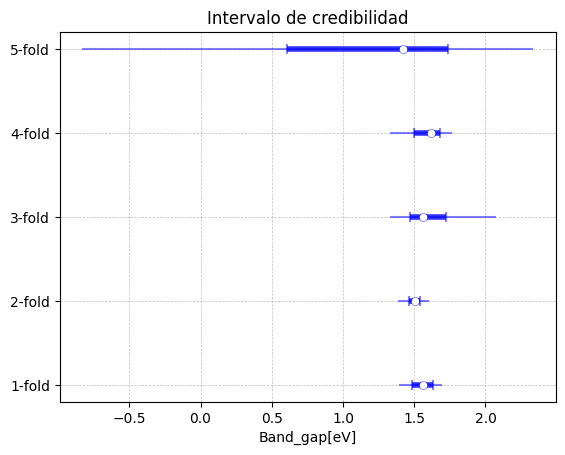

DeltaH
Intervalo de confianza al 0.90: (0.08, 0.45)
min = [-0.08354366334385677], max = [0.6988468642404988]
Valor porcentual HDI frente a la PDF =  46.71735334078568
Intervalo de confianza al 0.90: (0.08, 0.26)
min = [-0.08354366334385677, -0.07020201564715256], max = [0.6988468642404988, 0.4164519526039033]
Valor porcentual HDI frente a la PDF =  37.18738056478782
Intervalo de confianza al 0.90: (0.01, 0.88)
min = [-0.08354366334385677, -0.07020201564715256, -0.21362878576405225], max = [0.6988468642404988, 0.4164519526039033, 1.4147939803115808]
Valor porcentual HDI frente a la PDF =  53.01320603977512
Intervalo de confianza al 0.90: (0.10, 0.45)
min = [-0.08354366334385677, -0.07020201564715256, -0.21362878576405225, -0.09503701432360884], max = [0.6988468642404988, 0.4164519526039033, 1.4147939803115808, 0.7948990579420199]
Valor porcentual HDI frente a la PDF =  38.60658306052441
Intervalo de confianza al 0.90: (-0.50, 2.23)
min = [-0.08354366334385677, -0.07020201564715256, -0.2

<Figure size 800x500 with 0 Axes>

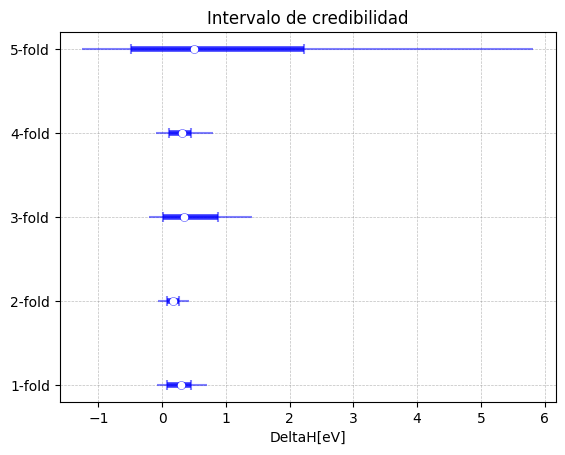

DeltaL
Intervalo de confianza al 0.90: (0.04, 0.40)
min = [-0.1841192477912551], max = [0.8041359278650333]
Valor porcentual HDI frente a la PDF =  35.83833785997266
Intervalo de confianza al 0.90: (0.10, 0.26)
min = [-0.1841192477912551, -0.049512800103117593], max = [0.8041359278650333, 0.3818877713870935]
Valor porcentual HDI frente a la PDF =  37.51484899836224
Intervalo de confianza al 0.90: (0.05, 0.56)
min = [-0.1841192477912551, -0.049512800103117593, -0.15922017057161855], max = [0.8041359278650333, 0.3818877713870935, 1.0984934992549298]
Valor porcentual HDI frente a la PDF =  40.79462764820424
Intervalo de confianza al 0.90: (0.19, 0.38)
min = [-0.1841192477912551, -0.049512800103117593, -0.15922017057161855, -0.14433788578510467], max = [0.8041359278650333, 0.3818877713870935, 1.0984934992549298, 0.5964073186716512]
Valor porcentual HDI frente a la PDF =  25.159671635225127
Intervalo de confianza al 0.90: (-0.17, 1.06)
min = [-0.1841192477912551, -0.049512800103117593, -0.1

<Figure size 800x500 with 0 Axes>

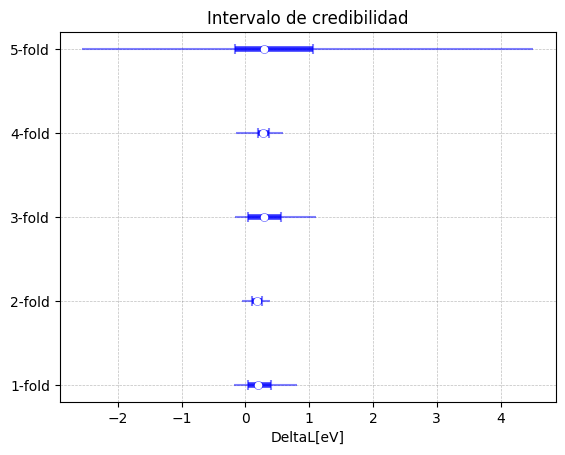

Grain_size
Intervalo de confianza al 0.90: (0.15, 1.22)
min = [-0.6055808857227558], max = [1.9627668533102602]
Valor porcentual HDI frente a la PDF =  41.72236876299813
Intervalo de confianza al 0.90: (0.50, 1.22)
min = [-0.6055808857227558, 0.06518981554556014], max = [1.9627668533102602, 1.6825739051876107]
Valor porcentual HDI frente a la PDF =  44.201418810505395
Intervalo de confianza al 0.90: (-1.38, 1.26)
min = [-0.6055808857227558, 0.06518981554556014, -2.9928732441178787], max = [1.9627668533102602, 1.6825739051876107, 1.9525675351451548]
Valor porcentual HDI frente a la PDF =  53.50216571267966
Intervalo de confianza al 0.90: (-0.62, 0.84)
min = [-0.6055808857227558, 0.06518981554556014, -2.9928732441178787, -2.690918397551051], max = [1.9627668533102602, 1.6825739051876107, 1.9525675351451548, 1.709963767432367]
Valor porcentual HDI frente a la PDF =  33.143259039178105
Intervalo de confianza al 0.90: (-1.80, 2.41)
min = [-0.6055808857227558, 0.06518981554556014, -2.9928732

<Figure size 800x500 with 0 Axes>

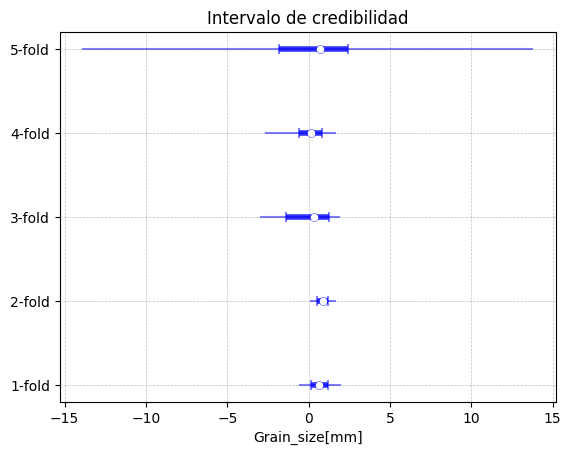

Thickness
Intervalo de confianza al 0.90: (0.30, 0.58)
min = [-0.04354265148096015], max = [1.038584385637397]
Valor porcentual HDI frente a la PDF =  25.510110864364716
Intervalo de confianza al 0.90: (0.31, 0.60)
min = [-0.04354265148096015, 0.11603622430575933], max = [1.038584385637397, 0.8061683532618635]
Valor porcentual HDI frente a la PDF =  40.922786726355284
Intervalo de confianza al 0.90: (0.04, 0.52)
min = [-0.04354265148096015, 0.11603622430575933, -0.6068060919908354], max = [1.038584385637397, 0.8061683532618635, 0.835052111189338]
Valor porcentual HDI frente a la PDF =  33.58212360756708
Intervalo de confianza al 0.90: (-0.09, 0.69)
min = [-0.04354265148096015, 0.11603622430575933, -0.6068060919908354, -0.8354377501013053], max = [1.038584385637397, 0.8061683532618635, 0.835052111189338, 0.9399842981179276]
Valor porcentual HDI frente a la PDF =  43.892631506673204
Intervalo de confianza al 0.90: (-1.46, 1.12)
min = [-0.04354265148096015, 0.11603622430575933, -0.6068060

<Figure size 800x500 with 0 Axes>

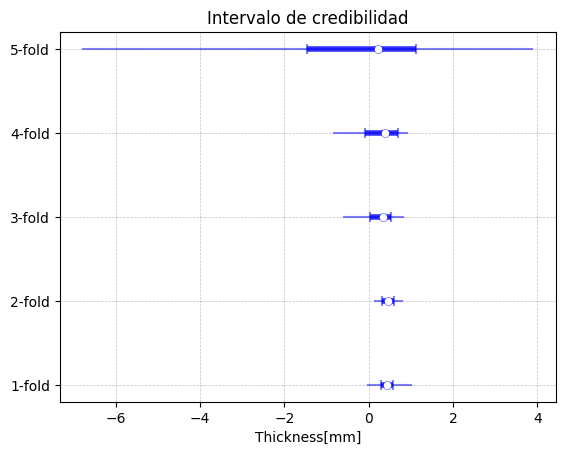

PCE
Intervalo de confianza al 0.90: (11.79, 20.08)
min = [10.076260651278691], max = [21.492011479613364]
Valor porcentual HDI frente a la PDF =  72.65727991103205
Intervalo de confianza al 0.90: (12.52, 18.45)
min = [10.076260651278691, 11.762900146675385], max = [21.492011479613364, 19.27956817633411]
Valor porcentual HDI frente a la PDF =  78.9153733308238
Intervalo de confianza al 0.90: (0.86, 20.37)
min = [10.076260651278691, 11.762900146675385, -3.3533645910653647], max = [21.492011479613364, 19.27956817633411, 21.51849427801114]
Valor porcentual HDI frente a la PDF =  78.44896268499217
Intervalo de confianza al 0.90: (12.24, 20.69)
min = [10.076260651278691, 11.762900146675385, -3.3533645910653647, 9.160673253537643], max = [21.492011479613364, 19.27956817633411, 21.51849427801114, 21.6837327401866]
Valor porcentual HDI frente a la PDF =  67.52314509167162
Intervalo de confianza al 0.90: (-10.00, 20.26)
min = [10.076260651278691, 11.762900146675385, -3.3533645910653647, 9.160673

<Figure size 800x500 with 0 Axes>

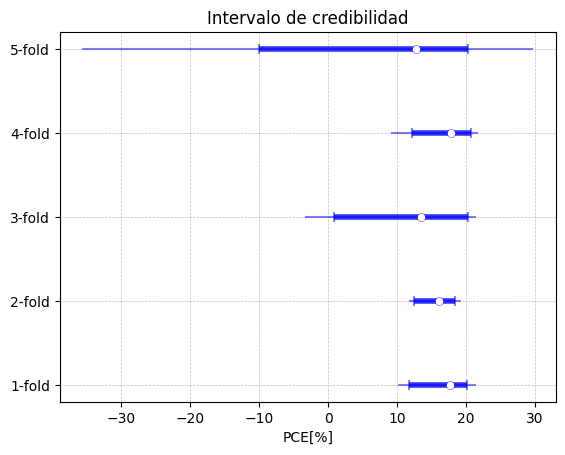

Voc
Intervalo de confianza al 0.90: (0.97, 1.17)
min = [0.8738971670826831], max = [1.237157067806464]
Valor porcentual HDI frente a la PDF =  55.61831695201423
Intervalo de confianza al 0.90: (0.96, 1.13)
min = [0.8738971670826831, 0.8948046628919266], max = [1.237157067806464, 1.2112068411752877]
Valor porcentual HDI frente a la PDF =  52.37040858844736
Intervalo de confianza al 0.90: (0.85, 1.14)
min = [0.8738971670826831, 0.8948046628919266, 0.7175576720938441], max = [1.237157067806464, 1.2112068411752877, 1.2450704310569853]
Valor porcentual HDI frente a la PDF =  55.146551516472684
Intervalo de confianza al 0.90: (0.95, 1.16)
min = [0.8738971670826831, 0.8948046628919266, 0.7175576720938441, 0.820799956081432], max = [1.237157067806464, 1.2112068411752877, 1.2450704310569853, 1.236573805940566]
Valor porcentual HDI frente a la PDF =  50.069544713736526
Intervalo de confianza al 0.90: (0.61, 1.27)
min = [0.8738971670826831, 0.8948046628919266, 0.7175576720938441, 0.82079995608143

<Figure size 800x500 with 0 Axes>

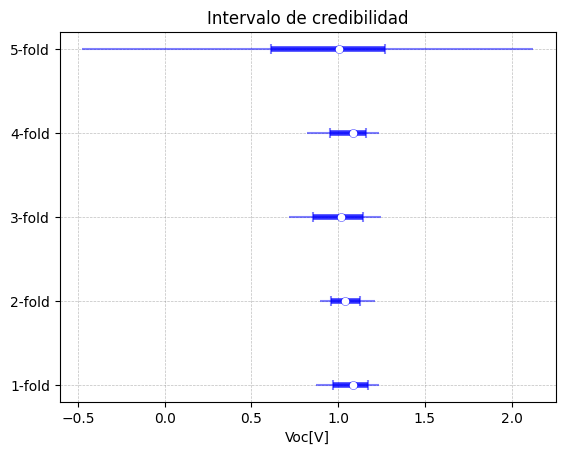

Jsc
Intervalo de confianza al 0.90: (18.05, 23.67)
min = [16.583099918532138], max = [25.26518199631634]
Valor porcentual HDI frente a la PDF =  64.75294812746371
Intervalo de confianza al 0.90: (18.76, 22.29)
min = [16.583099918532138, 17.961988924728796], max = [25.26518199631634, 22.979286313146982]
Valor porcentual HDI frente a la PDF =  70.35475252609398
Intervalo de confianza al 0.90: (-1.23, 22.97)
min = [16.583099918532138, 17.961988924728796, -5.494678363885608], max = [25.26518199631634, 22.979286313146982, 23.80511885191187]
Valor porcentual HDI frente a la PDF =  82.60260637229382
Intervalo de confianza al 0.90: (20.32, 24.13)
min = [16.583099918532138, 17.961988924728796, -5.494678363885608, 17.98340312978539], max = [25.26518199631634, 22.979286313146982, 23.80511885191187, 25.207907240595517]
Valor porcentual HDI frente a la PDF =  52.818137758594496
Intervalo de confianza al 0.90: (-9.36, 27.88)
min = [16.583099918532138, 17.961988924728796, -5.494678363885608, 17.98340

<Figure size 800x500 with 0 Axes>

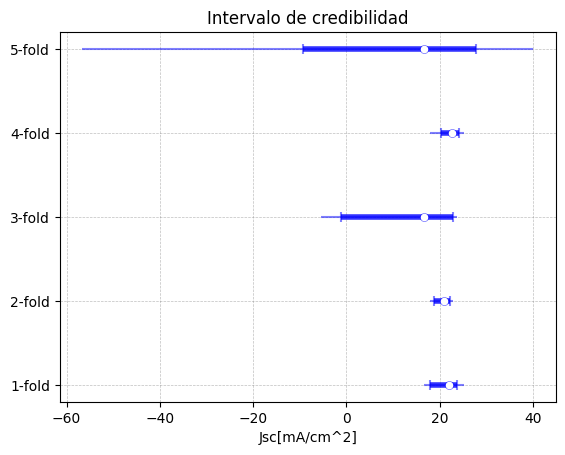

FF
Intervalo de confianza al 0.90: (0.68, 0.85)
min = [0.5947027037579092], max = [0.9643605858898006]
Valor porcentual HDI frente a la PDF =  44.30384108877676
Intervalo de confianza al 0.90: (0.67, 0.79)
min = [0.5947027037579092, 0.6277527468890085], max = [0.9643605858898006, 0.8535827373719447]
Valor porcentual HDI frente a la PDF =  53.4056364524618
Intervalo de confianza al 0.90: (0.63, 0.83)
min = [0.5947027037579092, 0.6277527468890085, 0.47465717577909844], max = [0.9643605858898006, 0.8535827373719447, 0.9128788694223822]
Valor porcentual HDI frente a la PDF =  44.59341239779756
Intervalo de confianza al 0.90: (0.65, 0.78)
min = [0.5947027037579092, 0.6277527468890085, 0.47465717577909844, 0.5580150569879665], max = [0.9643605858898006, 0.8535827373719447, 0.9128788694223822, 0.8351980713638822]
Valor porcentual HDI frente a la PDF =  46.09771438514707
Intervalo de confianza al 0.90: (0.57, 1.04)
min = [0.5947027037579092, 0.6277527468890085, 0.47465717577909844, 0.558015056

<Figure size 800x500 with 0 Axes>

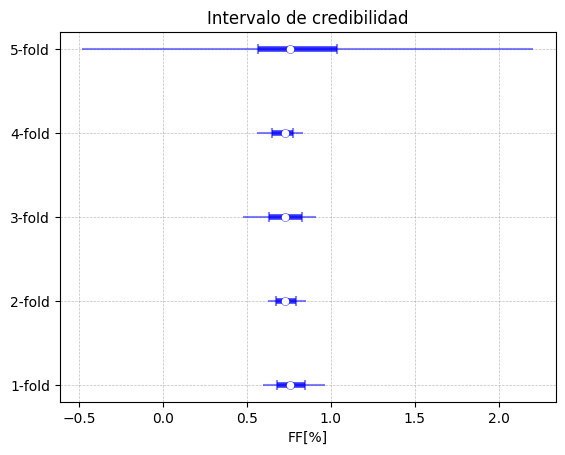

In [ ]:
alpha = 0.1
fold = ["1-fold", "2-fold", "3-fold", "4-fold", "5-fold"]
for datos in data[data.columns[3:]]:
  print(datos)
  ci_low = []
  ci_upper = []
  mean = []
  min = []
  max = []
  for i in range(1,6):
    lower_bound = np.percentile(prediccion[f"prediccion_{datos}"][f"fold_{i}"], alpha/2 * 100)
    upper_bound = np.percentile(prediccion[f"prediccion_{datos}"][f"fold_{i}"], (1 - alpha/2) * 100)
    min_ = np.min(prediccion[f"prediccion_{datos}"][f"fold_{i}"])
    max_ = np.max(prediccion[f"prediccion_{datos}"][f"fold_{i}"])
    min.append(np.min(prediccion[f"prediccion_{datos}"][f"fold_{i}"]))
    max.append(np.max(prediccion[f"prediccion_{datos}"][f"fold_{i}"]))
    ci_low.append(lower_bound)
    ci_upper.append(upper_bound)
    mean.append(np.mean(prediccion[f"prediccion_{datos}"][f"fold_{i}"]))
    print(f"Intervalo de confianza al {1-alpha:.2f}: ({lower_bound:.2f}, {upper_bound:.2f})")
    print(f"min = {min}, max = {max}")
    porcentaje_hdi = (upper_bound-lower_bound)/(max_-min_)*100
    print('Valor porcentual HDI frente a la PDF = ', porcentaje_hdi)
  # Crear un arreglo de posiciones para las barras horizontales
  positions = np.arange(len(fold))
  # Crear la figura y los ejes
  plt.figure(figsize=(8, 5))
  fig, ax = plt.subplots()
  # Dibujar las barras horizontales principales
  ax.hlines(positions, min, max, colors='b', alpha=0.5, linewidth=1.5)
  # Dibujar las barras horizontales secundarias
  ax.hlines(positions, ci_low, ci_upper, colors='b', alpha=0.8, linewidth=4)

  # Dibujar los puntos de estimación puntual
  ax.scatter(mean, positions, color='blue', marker='o', s = 30, zorder=10, alpha = 0.5)
  ax.scatter(mean, positions, color='white', marker='o', s = 20, zorder=10, alpha = 1)
  ax.scatter(ci_low, positions, color='blue', marker='|', s = 50, zorder=10, alpha = 0.5)
  ax.scatter(ci_upper, positions, color='blue', marker='|', s = 50, zorder=10, alpha = 0.5)
  # Etiquetas de los ejes
  ax.set_yticks(positions)
  ax.set_yticklabels(fold)
  ax.set_xlabel(f'{datos}[{unidades[datos]}]')
  #ax.set_ylabel('Parámetros')
  # Título del gráfico
  ax.set_title(f'Intervalo de credibilidad')
  # Mostrar el gráfico
  ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Imputacion/HDI/'
  plt.grid(True, **grid_style)
  plt.savefig(ruta + f'{datos}.png')
  plt.show()

## Grafico de relacion entre estimaciones y datos reales

Band_gap


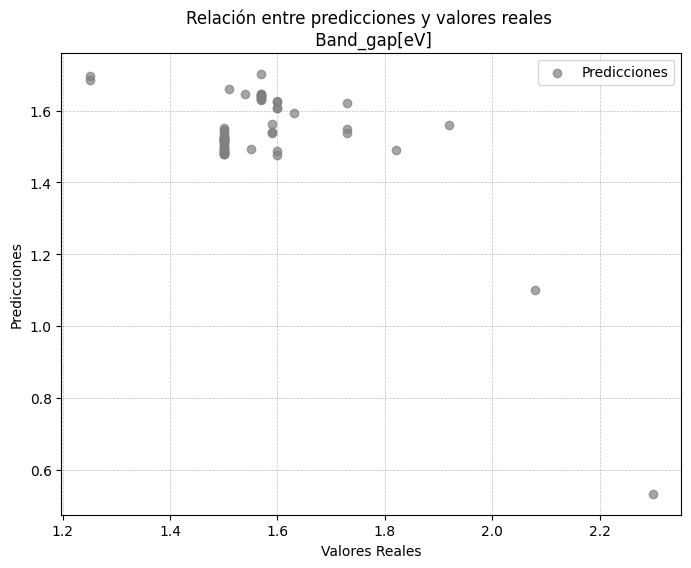

DeltaH


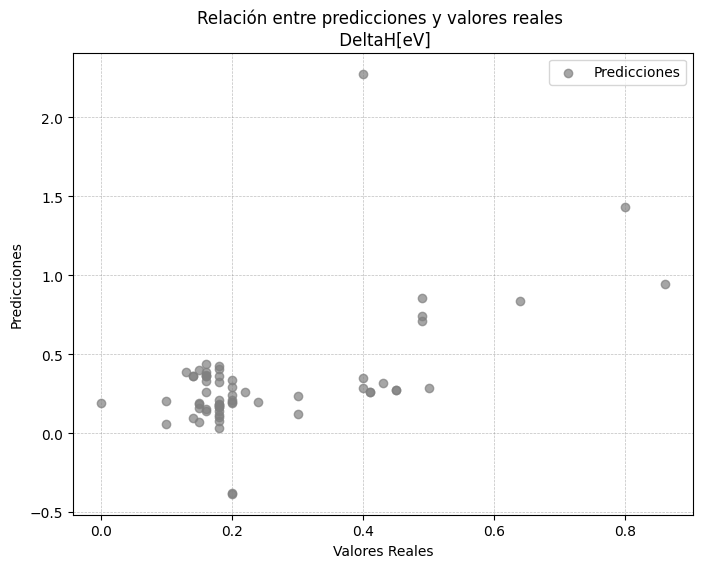

DeltaL


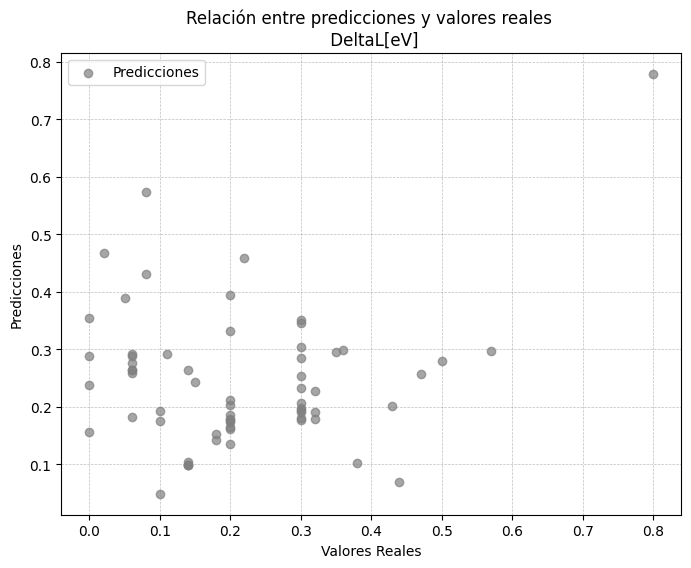

Grain_size


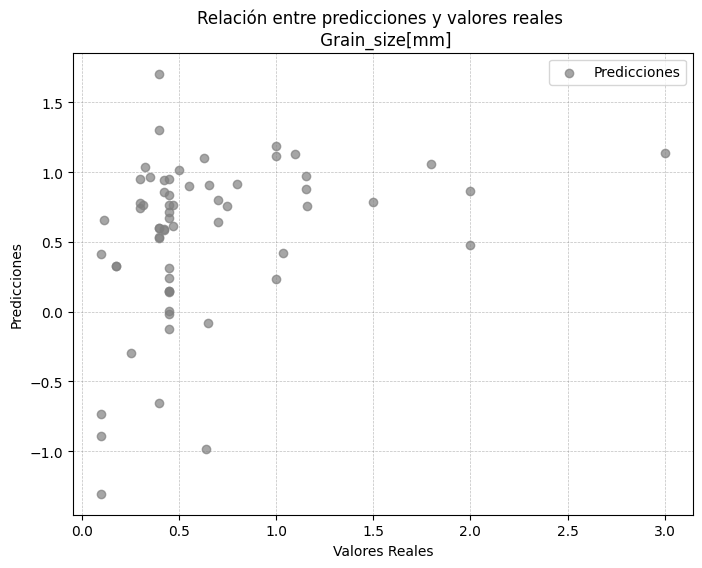

Thickness


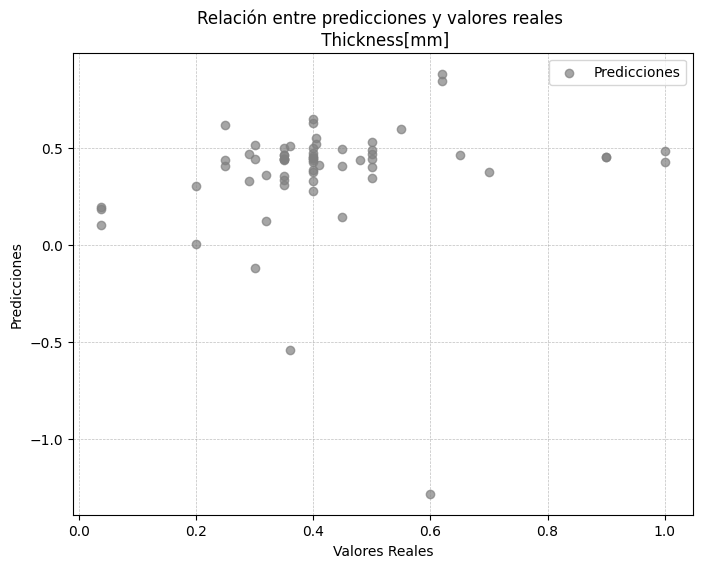

PCE


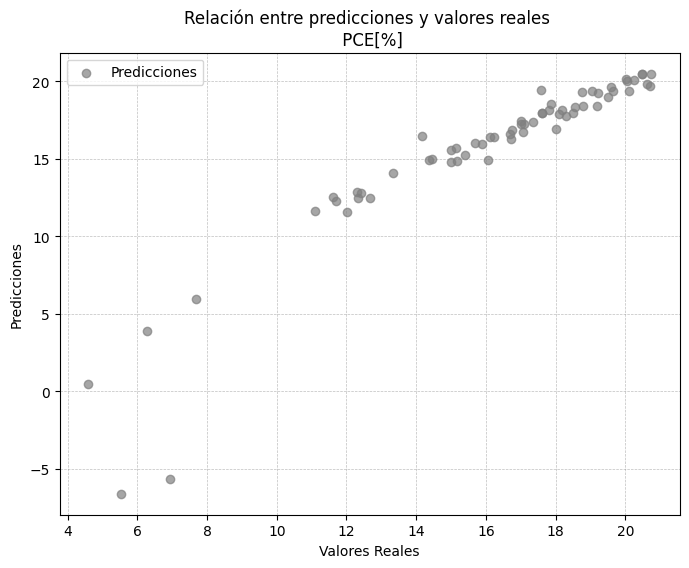

Voc


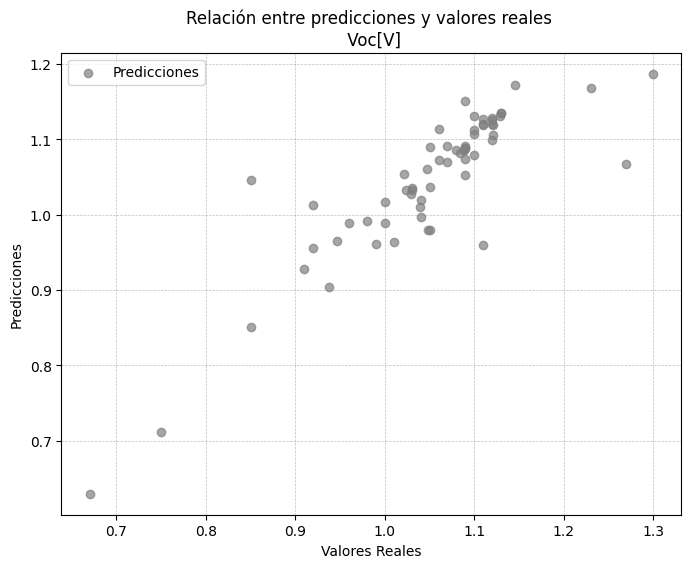

Jsc


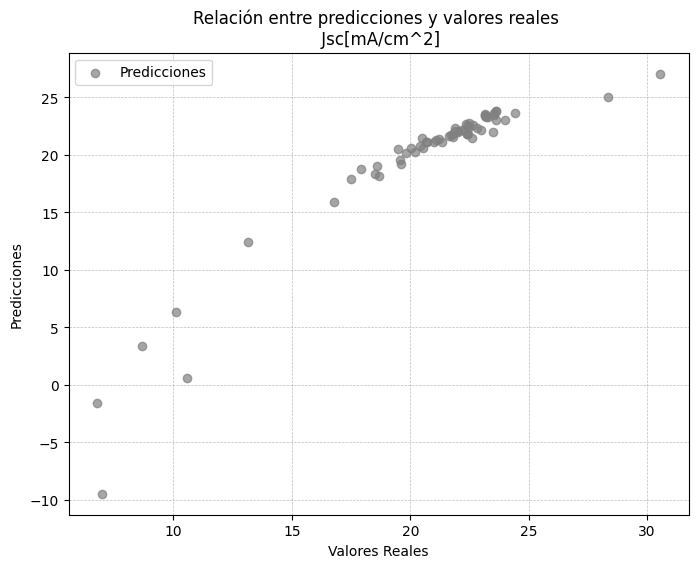

FF


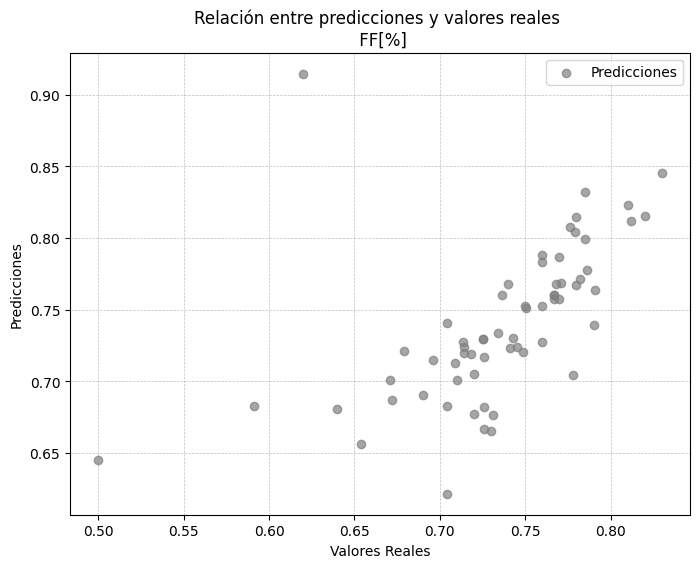

In [ ]:
ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Imputacion/CorrelacionPvR/'
for datos in data[data.columns[3:]]:
  print(datos)
  predicciones = []
  valor_real = []
  for i in range(1,6):
    predicciones.append(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
    valor_real.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
  valores_predichos = np.concatenate(predicciones)
  valores_reales = np.concatenate(valor_real)
  plt.figure(figsize=(8, 6))
  plt.scatter(valores_reales, valores_predichos, label='Predicciones', color='gray', alpha = 0.7)
  plt.xlabel(f'Valores Reales')
  plt.ylabel('Predicciones')
  plt.title(f'Relación entre predicciones y valores reales \n {datos}[{unidades[datos]}]')
  plt.legend()
  # Guarda la figura en un archivo (por ejemplo, en formato PNG) en la carpeta de Drive
  plt.grid(True, **grid_style)
  plt.savefig(ruta + f'{datos}.png')
  plt.show()

## Grafico de comparacion de estimaciones vs datos reales

Band_gap
[1.53437206 1.56305448 1.49266444 1.49369354 1.59242485 1.54855301
 1.53724706 1.60720852 1.60720852 1.62768815 1.62290486 1.54092887
 1.53802653]
[1.4799034  1.52549969 1.51677387 1.4962224  1.50939398 1.47897862
 1.49646477 1.48671479 1.48856124 1.51447063 1.4854134  1.52524619
 1.52360518]
[1.5194429  1.48320486 1.54656616 1.49911591 1.62200989 1.52086524
 1.64546926 1.70297931 1.66163802 1.50341319 1.55278518 1.51679347
 1.51407053]
[1.52023368 1.52776544 1.64691068 1.64691068 1.64299159 1.64147401
 1.64042451 1.64100233 1.63176758 1.62974979 1.63520018 1.63221319]
[1.49130889 1.5182122  1.54329449 1.68563877 1.47791624 1.09909341
 1.47860866 1.48815783 1.69544218 1.48703586 1.56134428 0.53285064]


<Figure size 800x500 with 0 Axes>

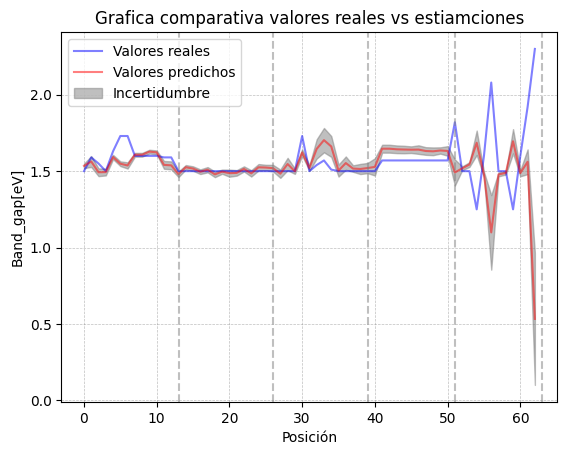

DeltaH
[0.0712571  0.28363487 0.20516099 0.3498385  0.25869015 0.36291696
 0.42475792 0.25794412 0.25794412 0.27448567 0.27315331 0.361385
 0.36148538]
[0.21084611 0.15996623 0.16485445 0.18299013 0.18233056 0.13816705
 0.17956408 0.11195609 0.24355411 0.19820969 0.19008104 0.10003395
 0.16594728]
[0.32649222 0.03092941 0.43838515 0.09248856 0.315757   0.07619247
 0.71214897 0.85335678 0.73867109 0.06029901 0.28736973 0.12360392
 0.40386672]
[0.18873138 0.33910197 0.36407927 0.36407927 0.37015522 0.38833081
 0.32976988 0.15523791 0.38684456 0.39796119 0.26115712 0.13690529]
[ 0.83462358  0.21125088  0.17839535 -0.38384718  0.28898536  1.42909778
  0.18966587  0.19816963 -0.38181347  0.23344031  0.94619829  2.27537867]


<Figure size 800x500 with 0 Axes>

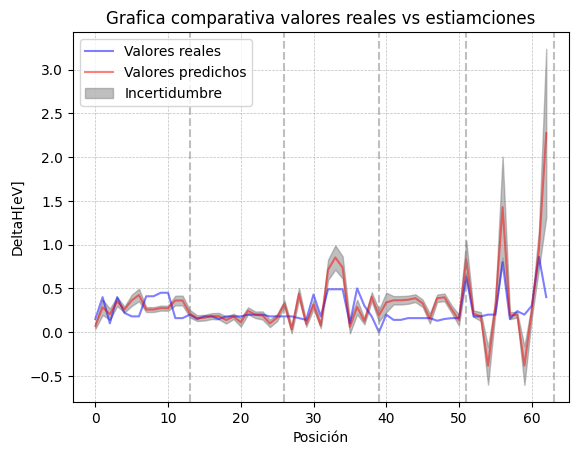

DeltaL
[0.1733265  0.23316605 0.25678611 0.21183443 0.15295667 0.19019254
 0.20191973 0.09814404 0.09814404 0.09839746 0.10363701 0.33232215
 0.3512977 ]
[0.18999614 0.25378751 0.20264872 0.16474504 0.17626307 0.13506415
 0.17887273 0.16036918 0.15558034 0.19341507 0.17643508 0.17916225
 0.19690273]
[0.29217249 0.10275671 0.45777347 0.20660636 0.14206645 0.17969613
 0.38845275 0.4669734  0.43081464 0.3033119  0.28469873 0.04859854
 0.39360577]
[0.34547873 0.2369557  0.26427555 0.26427555 0.25899432 0.27627852
 0.26289369 0.28003675 0.28768815 0.29115875 0.2990517  0.29684644]
[0.06945596 0.18485522 0.22747064 0.24267382 0.35477087 0.57377528
 0.1916969  0.17486768 0.29469527 0.28810429 0.18184911 0.77895313]


<Figure size 800x500 with 0 Axes>

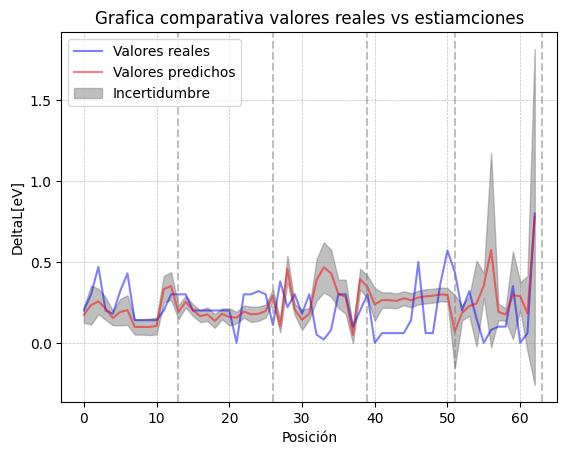

Grain_size
[0.87733682 1.13831076 1.05936935 0.41451749 0.64337656 0.80011647
 0.6580832  0.5968481  0.5968481  0.5248102  0.53233069 0.32521352
 0.32592703]
[0.77782617 0.96957941 0.91306439 0.90394949 0.74284736 0.95409202
 0.90832305 0.76823639 0.58831888 0.5956583  1.09987686 1.01825111
 1.13230754]
[ 0.42364647  1.04014309  0.47679325  0.76571394  1.11743109  1.1896781
 -0.73135143 -1.30558344 -0.89474217  0.76732484  0.61336998  0.96326972
  0.23459249]
[-0.08233504 -0.65684975  0.1470854   0.1470854   0.14248006 -0.01760491
  0.23818568  0.71458933  0.00467172 -0.12521988  0.31642837  0.67215579]
[-0.29754242  0.78839223  0.86435241  0.95346845  1.30472177  0.75628853
  0.94314237  0.85959986  0.83929669  1.70637407  0.76019645 -0.98564644]


<Figure size 800x500 with 0 Axes>

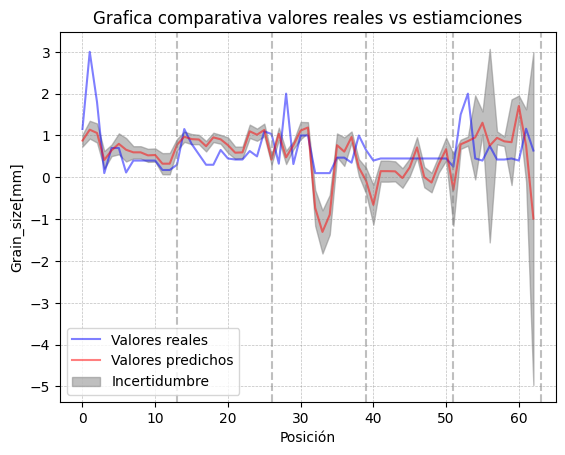

Thickness
[0.50883315 0.52863032 0.49561545 0.3769775  0.42975361 0.40047105
 0.34453283 0.46383935 0.46383935 0.43647274 0.44083373 0.45285871
 0.45357136]
[0.4587463  0.46952606 0.48802401 0.44112565 0.44458334 0.49903816
 0.44405048 0.41172281 0.33195695 0.3558609  0.51547466 0.5989019
 0.46828593]
[0.3278029  0.43901707 0.303349   0.44239077 0.46342972 0.43505703
 0.19493215 0.10361992 0.18720985 0.48242117 0.4267433  0.4040918
 0.36195434]
[ 0.12172422 -0.11906692  0.44752046  0.44752046  0.43855971  0.37760062
  0.47162447  0.64969     0.38851105  0.33109523  0.49928301  0.62677961]
[ 0.00313115  0.31039196  0.27934934  0.88231247  0.40746721 -0.54186395
  0.55238939  0.51794658  0.84380649  0.61659213  0.14474821 -1.28298376]


<Figure size 800x500 with 0 Axes>

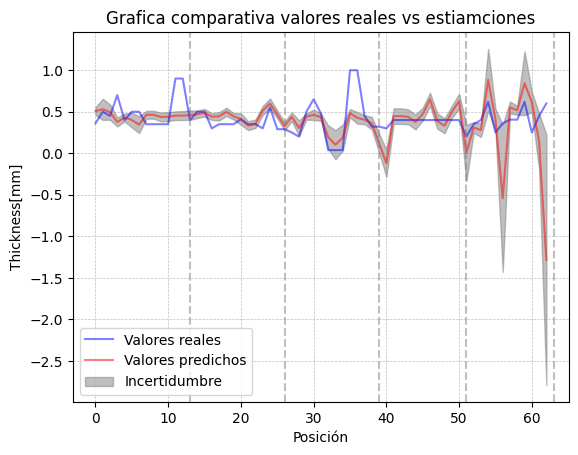

PCE
[19.70880694 19.38663702 16.89646168 11.64242216 19.78729994 17.95119065
 14.82189948 17.91596424 17.91596424 17.25314634 17.45218683 20.01655296
 19.24056596]
[12.81947156 17.91297023 18.31826154 16.01549726 16.37997419 15.96073402
 16.37465331 15.25410618 15.65986314 12.4848861  15.58879113 18.42069065
 17.39048209]
[14.90794812 14.76174786 14.06236503 16.57695279 20.45822898 18.96136135
  5.93941451  0.46305938  3.89918781 19.38593732 14.98415515 18.38383359
 12.51182043]
[12.75861496 12.27835832 20.48022111 20.48022111 20.13703507 19.39136025
 19.60505602 17.72501233 19.27279623 18.52201595 16.87748428 16.29537263]
[11.56399046 18.15183619 17.25651797 19.44103322 12.48407116 -6.62139725
 20.05371717 18.13358791 16.44475512 16.70626588 14.91902539 -5.67231984]


<Figure size 800x500 with 0 Axes>

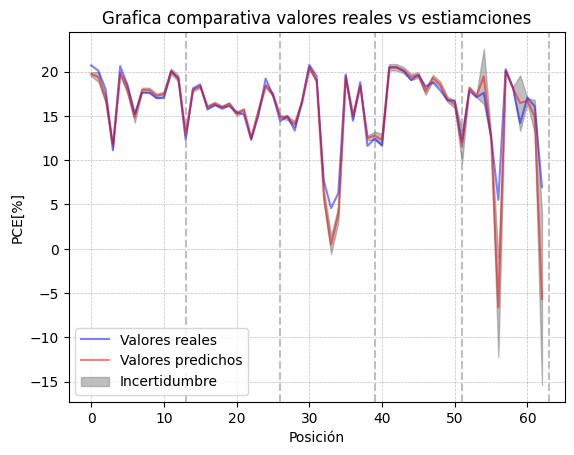

Voc
[1.12015296 1.03514239 1.01225675 0.96441295 1.17231165 1.08818719
 1.08945216 1.08613497 1.08613497 1.11873719 1.10552371 1.10690643
 1.11232165]
[0.95587705 1.06910208 1.08150999 1.03293556 1.08811928 1.01607158
 1.02749785 1.01940696 1.00980882 1.03238634 0.98882839 1.13142096
 1.07193642]
[0.96136877 1.0535412  0.90402825 1.06080424 1.13071297 1.12638414
 0.97968719 0.99687751 0.96304321 1.08526875 0.98830539 1.12574018
 0.8514325 ]
[0.97998323 0.95941622 1.13426022 1.13426022 1.11969812 1.09869813
 1.11821207 1.15101884 1.07418573 1.05255192 1.09120528 1.11347689]
[1.1868725  1.07948764 1.03709266 0.71163651 0.928247   1.04591798
 1.12750034 1.09116476 0.62959293 0.99117028 1.1681947  1.06745274]


<Figure size 800x500 with 0 Axes>

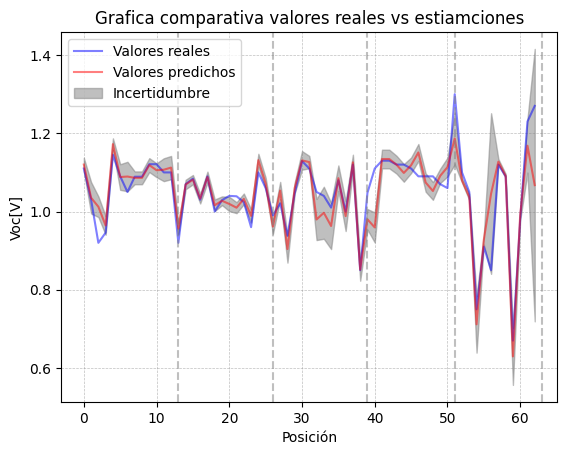

Jsc
[22.99770953 21.98356959 22.5177748  17.91157946 23.32192833 23.64627729
 21.48717774 21.80666579 21.80666579 21.08712979 21.08712979 23.31912608
 22.72746984]
[18.99703589 22.09963521 22.17556978 20.81468261 20.47253329 21.58193752
 21.25989846 22.15879603 21.15604737 18.74307148 20.13869743 21.99320564
 21.15993608]
[20.29443723 21.62215379 19.53081827 21.40464658 23.03179593 22.61113792
  6.32313726 -1.54799959  3.35225962 22.45270322 18.33670034 21.83253091
 18.17472461]
[20.58778935 20.57991409 23.82679828 23.82679828 23.68366197 23.46928226
 23.50319405 22.32386992 23.52895522 23.41117247 22.0531724  21.84349461]
[12.45838861 22.32680009 22.78832587 27.05705508 19.23366491  0.60308138
 22.16444592 21.69053361 25.02237613 21.49435709 15.90223338 -9.45979729]


<Figure size 800x500 with 0 Axes>

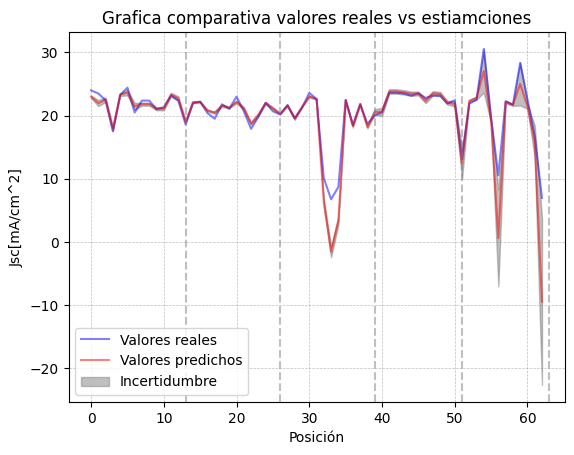

FF
[0.81476022 0.8455348  0.81559074 0.70084998 0.78325563 0.71520121
 0.69042417 0.72977813 0.72977813 0.72370676 0.71953634 0.77761215
 0.77136112]
[0.70493209 0.76828673 0.76833565 0.72022279 0.72771993 0.71690018
 0.72386481 0.68086454 0.68295088 0.68700702 0.73936322 0.79916887
 0.76388284]
[0.67728725 0.72133024 0.66695903 0.75272456 0.80458103 0.80802237
 0.66566348 0.65600437 0.68227822 0.82307376 0.76739276 0.78657567
 0.67680146]
[0.68309373 0.64547325 0.76013255 0.76013255 0.7527192  0.73395799
 0.75089164 0.76009898 0.73032751 0.71300632 0.72779953 0.74047295]
[0.62163491 0.72317454 0.71901945 0.7880503  0.70090463 0.91467679
 0.81171478 0.75722118 0.76770316 0.75761554 0.70479465 0.83224071]


<Figure size 800x500 with 0 Axes>

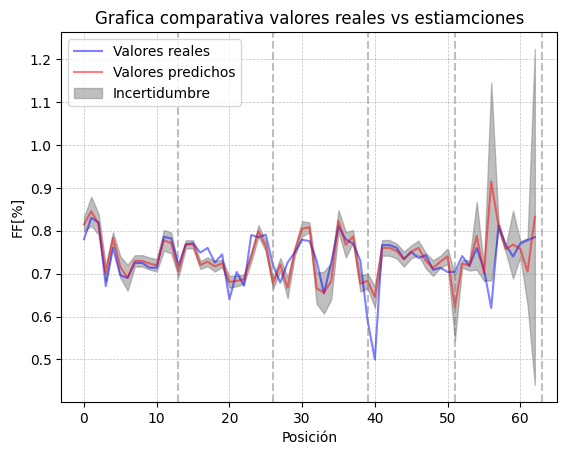

In [ ]:
# Especifica la ruta de la carpeta en Google Drive donde deseas guardar la imagen
ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Imputacion/Comportamiento_predicciones/'
for datos in data[data.columns[3:]]:
  print(datos)
  predicciones = []
  desviaciones_std = []
  valor_real = []
  posiciones = []
  for i in range(1,6):
    predicciones.append(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
    desviaciones_std.append(desviacion_std[f"desviacion_std_{datos}"][f"fold_{i}"])
    print(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
    posiciones.append(len(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"]))
    valor_real.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
  valores_predichos = np.concatenate(predicciones)
  desviaciones_std = np.concatenate(desviaciones_std)
  valor_superior = np.array(valores_predichos) + np.array(desviaciones_std)
  valor_inferior = np.array(valores_predichos) - np.array(desviaciones_std)
  valores_reales = np.concatenate(valor_real)
  x = np.arange(len(valores_predichos))
  # Crear la figura y los ejes
  plt.figure(figsize=(8, 5))
  fig, ax = plt.subplots()

  # Graficar los valores en función de las posiciones con colores diferentes
  ax.plot(x, valores_reales, color='blue', linestyle='-', label='Valores reales', alpha = 0.5)
  ax.plot(x, valores_predichos, color='red', linestyle='-', label='Valores predichos', alpha = 0.5)
  ax.fill_between(x, valor_superior, valor_inferior, color='gray', alpha=0.5, label='Incertidumbre')
  nueva_posicion = 0
  for posicion in posiciones:
    nueva_posicion = posicion + nueva_posicion
    ax.axvline(x=nueva_posicion, color='gray', linestyle='--', alpha = 0.5)
  # Etiquetas de los ejes
  ax.set_xlabel('Posición')
  ax.set_ylabel(f'{datos}[{unidades[datos]}]')


  # Título de la gráfica
  ax.set_title(f'Grafica comparativa valores reales vs estiamciones')
  # Leyenda
  ax.legend()
  plt.grid(True, **grid_style)
  # Guarda la figura en un archivo (por ejemplo, en formato PNG) en la carpeta de Drive
  plt.savefig(ruta + f'{datos}.png')
  # Mostrar la gráfica
  plt.show()

## Grafico de densidad conjunta de las predicciones vs los datos reales

In [ ]:
#for datos in data[data.columns[3:]]:
#  print(datos)
#  predicciones = []
#  valor_real = []
#  for i in range(1,6):
#    predicciones.append(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
#    valor_real.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
#  valores_predichos = np.concatenate(predicciones)
#  valores_reales = np.concatenate(valor_real)
#  # Crear un DataFrame con los datos
#  df_data = pd.DataFrame({'Valores Predichos': valores_predichos, 'Valores Reales': valores_reales})
#
#  # Crear el gráfico de densidad conjunta
#  sns.jointplot(data=df_data, x='Valores Predichos', y='Valores Reales', kind='kde')
#  #plt.title(f"Grafico de densidad conjunta para {datos}")
#  # Mostrar el gráfico
#  plt.show()
#

## Densidad posterior predictiva

Band_gap


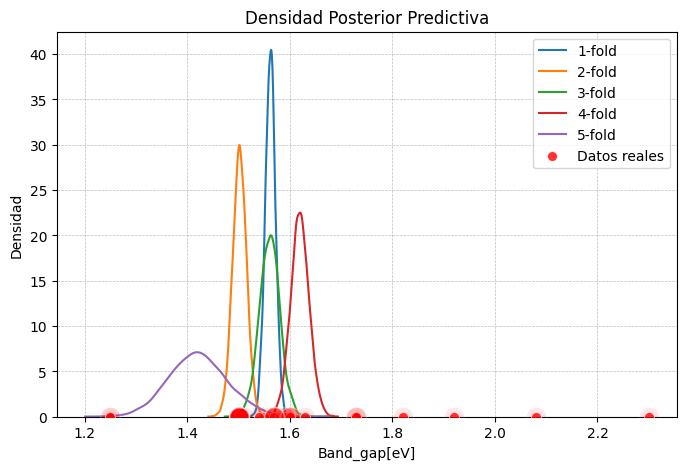

DeltaH


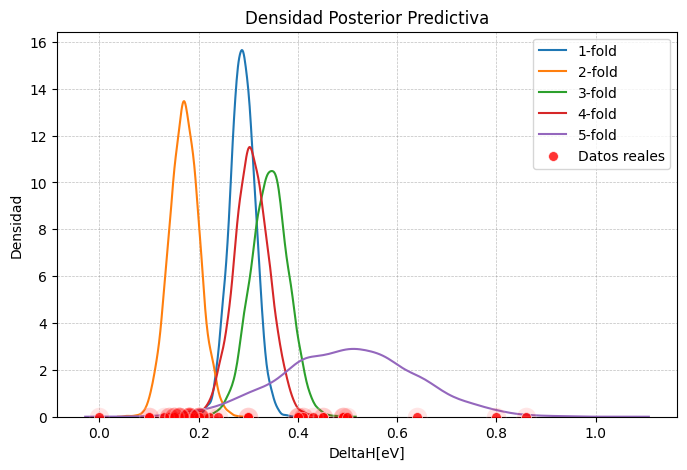

DeltaL


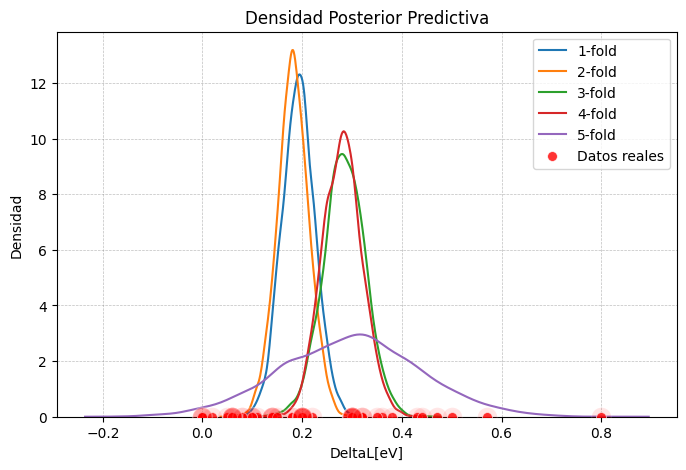

Grain_size


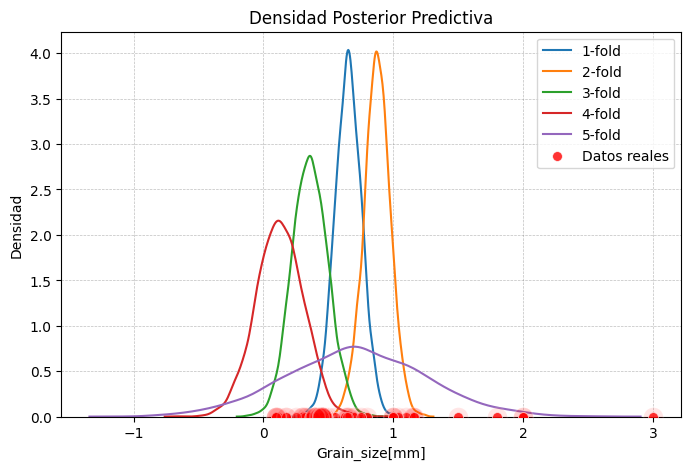

Thickness


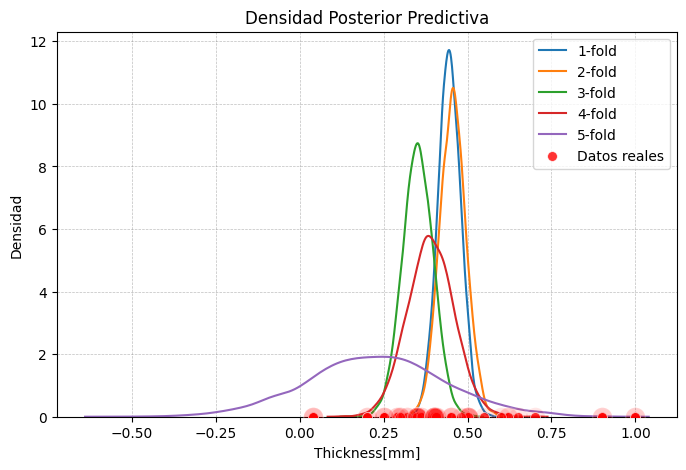

PCE


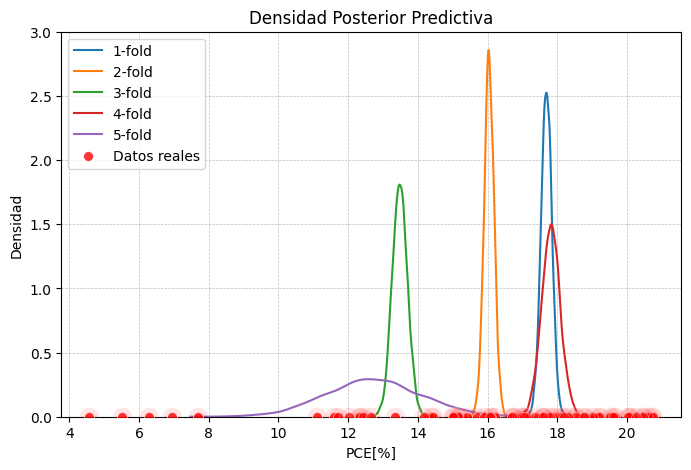

Voc


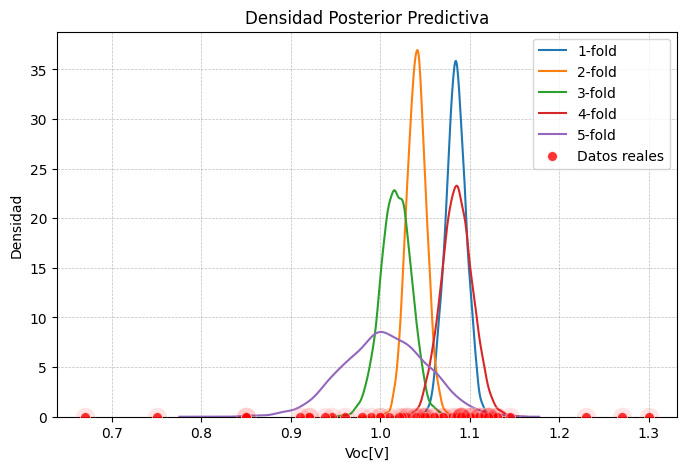

Jsc


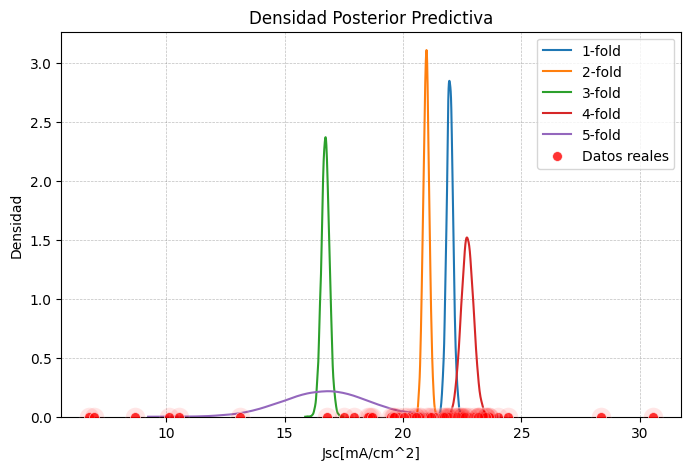

FF


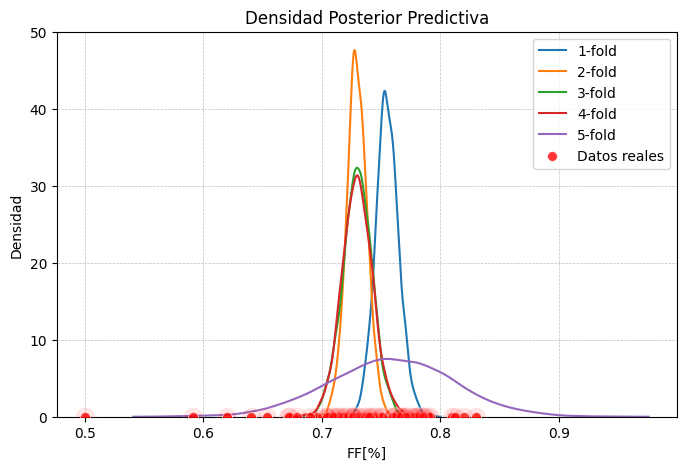

In [ ]:
# PDF de las predicciones (ejemplo)
ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Imputacion/DPP/'
for datos in data[data.columns[3:]]:
  print(datos)
  densidad_predicciones = []
  test = []
  predicciones_ = []
  for i in range(1,6):
    pdf_predicciones = prediccion[f"prediccion_{datos}"][f"fold_{i}"]
    densidad_prediccion = np.mean([pdf_predicciones[j] for j in range(len(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test']))], axis=0)
    densidad_predicciones.append(densidad_prediccion)
    test.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
    predicciones_.append(pdf_predicciones)
  test = np.concatenate(test)
  densidad_predicciones = np.asarray(densidad_predicciones)
  # Crear el gráfico
  plt.figure(figsize=(8, 5))
  # Histograma de los datos de prueba
  for i in range(0,5):
    posterior_predictive = sns.kdeplot(densidad_predicciones[i], label = f'{i+1}-fold')
  sns.scatterplot(x=test, y=np.zeros_like(test), color='red', marker='o',s = 50, zorder=10, alpha = 0.8, label = "Datos reales")
  sns.scatterplot(x=test, y=np.zeros_like(test), color='r', marker='o',s = 200, alpha = 0.1, zorder=10)
  plt.xlabel(f"{datos}[{unidades[datos]}]")
  plt.ylabel('Densidad')
  plt.title(f'Densidad Posterior Predictiva')
  plt.grid(True, **grid_style)
  # Guarda la figura en un archivo (por ejemplo, en formato PNG) en la carpeta de Drive
  plt.savefig(ruta + f'{datos}.png')
  plt.show()


##Grafico del trazado para cada variable y cada modelo generado

In [ ]:
#for datos in data[data.columns[8:9]]:
#  print(datos)
#  for i in range(1,6):
#    idata = az.convert_to_inference_data(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'])
#    print(datos, f'fold#{i}')
#    az.plot_trace(idata, var_names = ['A', "B", "X", "Band_gap"], kind = "trace", figsize=(10,10))
#    plt.tight_layout()
#    az.plot_trace(idata, var_names = ["DeltaH", "DeltaL",'Grain_size', "Thickness"], kind = "trace", figsize=(10,10))
#    plt.tight_layout()
#    az.plot_trace(idata, var_names = ["PCE", "Voc", "Jsc", "FF"], kind = "trace", figsize=(10,10))
#    plt.tight_layout()
#    plt.show()

<Figure size 800x500 with 0 Axes>

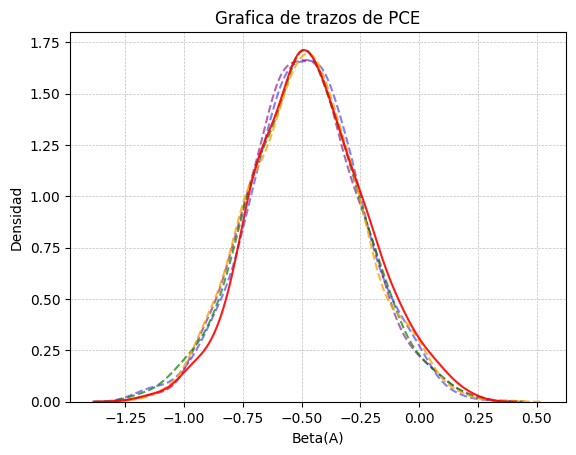

<Figure size 800x500 with 0 Axes>

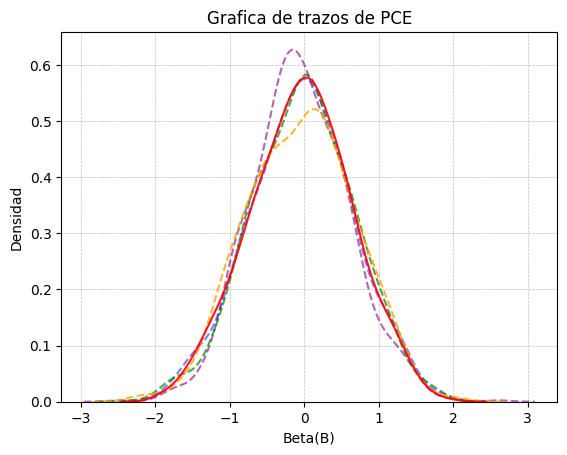

<Figure size 800x500 with 0 Axes>

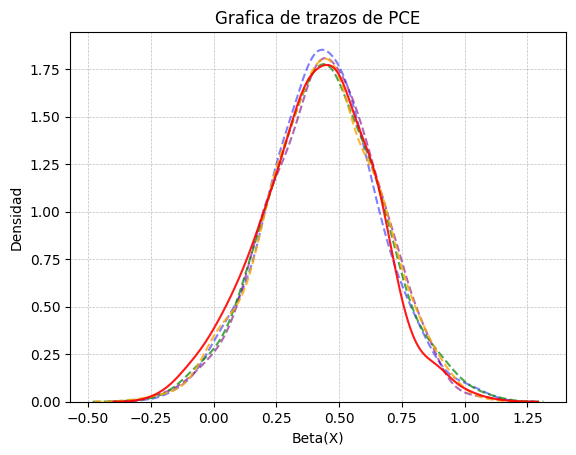

<Figure size 800x500 with 0 Axes>

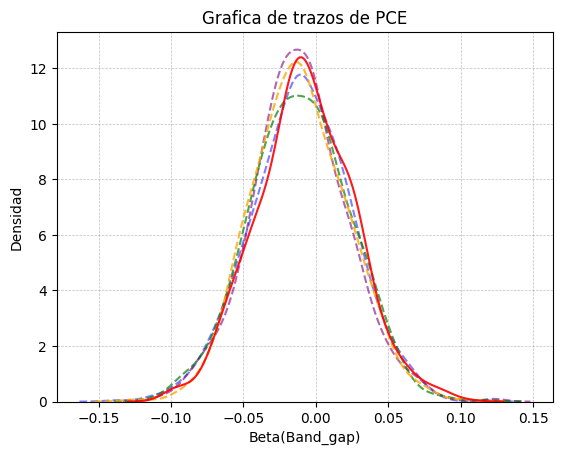

<Figure size 800x500 with 0 Axes>

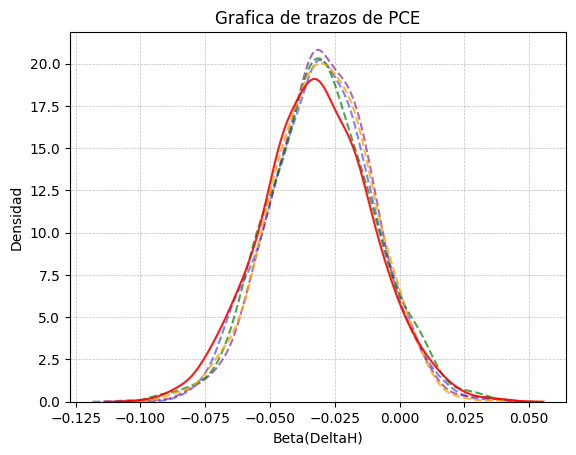

<Figure size 800x500 with 0 Axes>

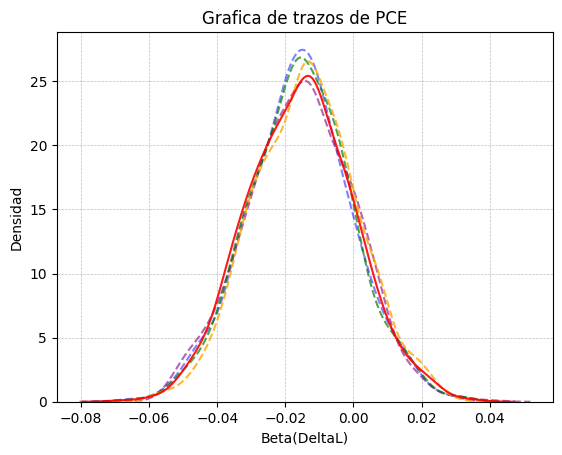

<Figure size 800x500 with 0 Axes>

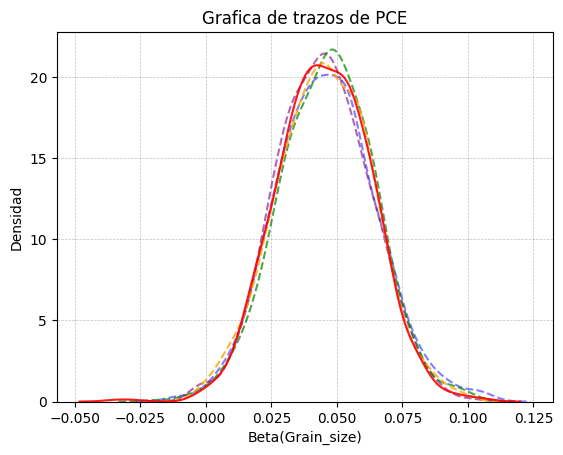

<Figure size 800x500 with 0 Axes>

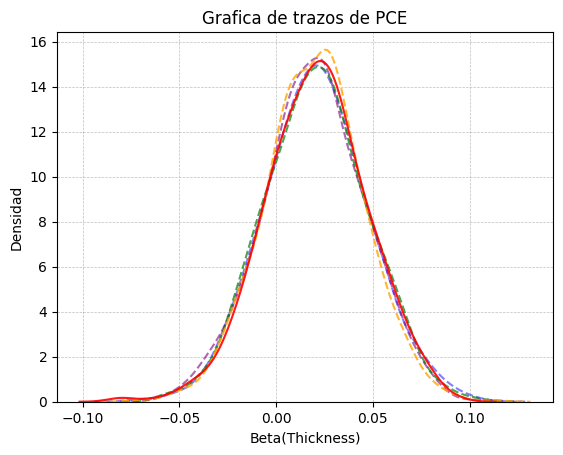

<Figure size 800x500 with 0 Axes>

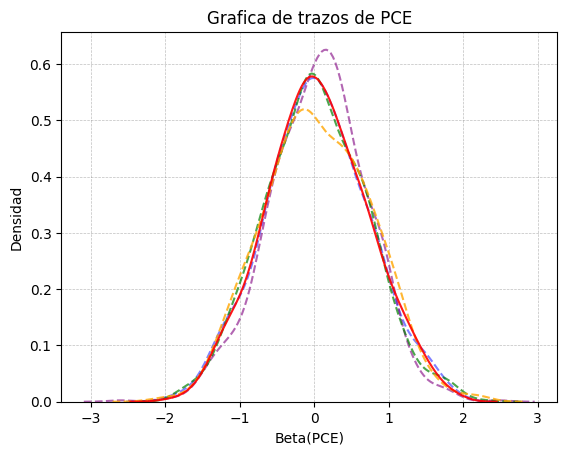

<Figure size 800x500 with 0 Axes>

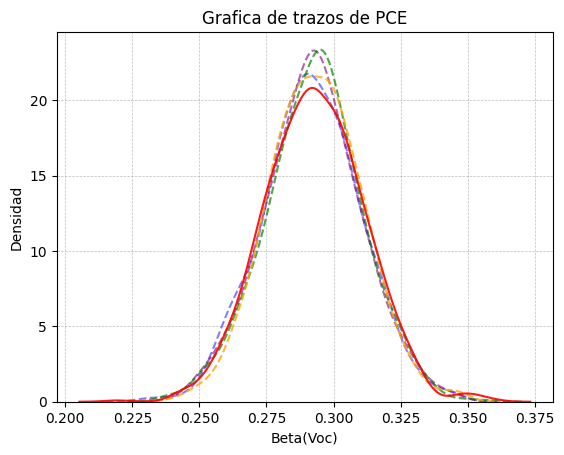

<Figure size 800x500 with 0 Axes>

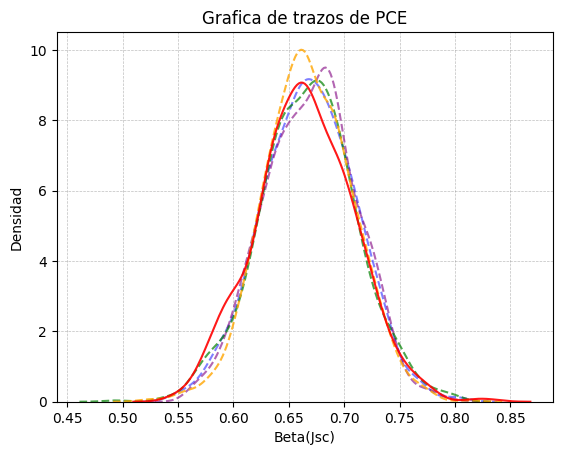

<Figure size 800x500 with 0 Axes>

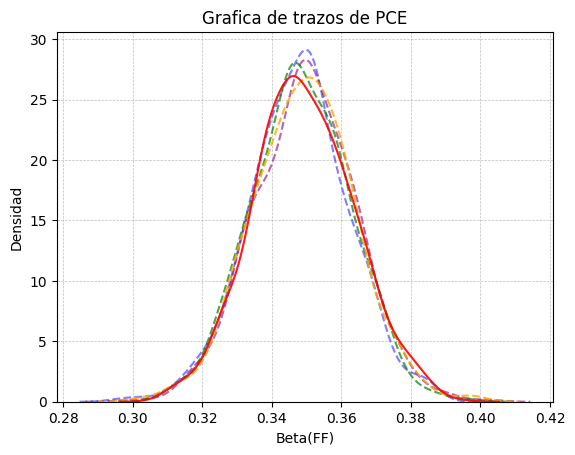

In [ ]:
names = ['A','B','X', 'Band_gap', 'DeltaH', 'DeltaL', 'Grain_size', 'Thickness', "PCE", "Voc", "Jsc", "FF"]
grid_style = {'color': 'gray', 'linestyle': '--', 'linewidth': 0.5, 'alpha': 0.5}
estilo_linea = ["--", "--", "--", "--", "-"]
transparencia = [0.5, 0.6, 0.7, 0.8, 0.9]
colores = ['b', 'purple', 'g', 'orange', 'r']
for datos in data[data.columns[8:9]]:
  for i in range(5,6):
    for name in names:
      plt.figure(figsize=(8, 5))
      fig, ax = plt.subplots()
      for j in range (0,5):
        sns.kdeplot(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'][name][j], linestyle=estilo_linea[j], alpha = transparencia[j], color = colores[j])
        plt.title(f"Grafica de trazos de {datos}")
        plt.ylabel("Densidad")
        plt.xlabel(f"Beta({name})")
        plt.grid(True, **grid_style)
        ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Imputacion/SAMPLEO/'
        plt.savefig(ruta + f'trazos_{datos}_{name}.png')
      plt.show()